In [4]:
!pip install wordcloud
!pip install xgboost
!pip install tokenizers

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/75/dd/9afe0d9d0f61a5384c3932626a022e38c396a5d88e6f5345ad2f7b576747/xgboost-1.7.6-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 70.9/70.9 MB 8.3 MB/s eta 0:00:00


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

In [2]:
data=pd.read_csv('data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
data.describe() #descriptive statistics

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
null_values = data.isnull().sum() #identifying missing values

In [6]:
null_values.index[0]

'review'

In [7]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


In [8]:
num_duplicates = data.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [9]:
#view duplicate reviews
review = data['review']
duplicated_review = data[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [10]:
#drop duplicate reviews
data.drop_duplicates(inplace = True)

In [11]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(data.shape[0],data.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop = stopwords.words('english')
wl = WordNetLemmatizer()

In [14]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

In [15]:
#function to clean data
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

In [16]:
data_copy = data.copy()

In [21]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


True

In [22]:
data['review']=data['review'].apply(clean_text,lemmatize = True)

c:\Users\hp\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [36]:
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter matteis love time money visually stunni...,1


In [37]:
train, test= train_test_split(data, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [38]:
tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

Logistic Regression Accuracy : 89.03%


c:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


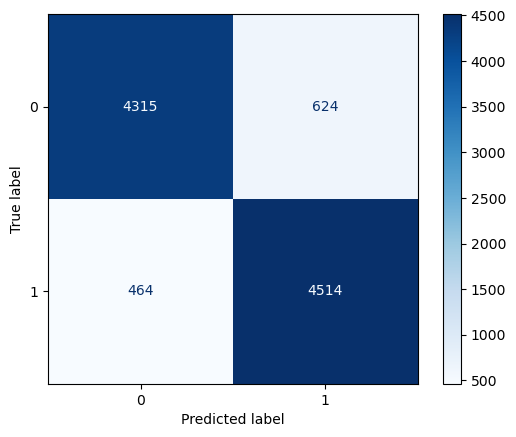

In [39]:
lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(lr, Xtest_tfidf, ytest,cmap = 'Blues')
plt.grid(False)

Multinomial Naive Bayes Classifier Accuracy : 86.79%


c:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


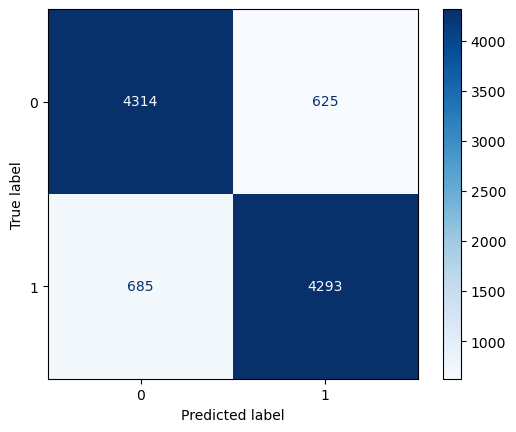

In [40]:
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(mnb, Xtest_tfidf, ytest,cmap = 'Blues')
plt.grid(False)

Linear Support Vector Classifier Accuracy : 89.57%


c:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


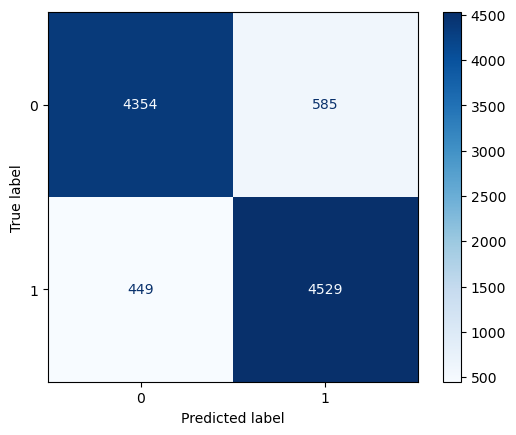

In [41]:
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))
plot_confusion_matrix(linear_svc, Xtest_tfidf, ytest,cmap = 'Blues')
plt.grid(False)


XGBoost Accuracy : 84.63%


c:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


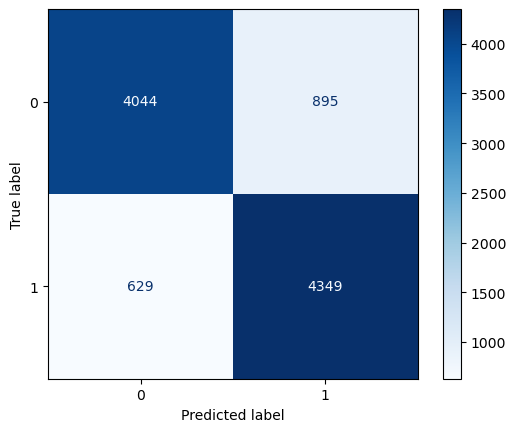

In [44]:
xgbo = XGBClassifier()
xgbo.fit(Xtrain_tfidf,ytrain)
p4=xgbo.predict(Xtest_tfidf)
s4=accuracy_score(ytest,p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100*s4))
plot_confusion_matrix(xgbo, Xtest_tfidf, ytest, cmap = 'Blues')
plt.grid(False)